In [3]:
"""
Credits to https://github.com/CompVis/taming-transformers
"""

from dataclasses import dataclass
from typing import Any, Tuple


from einops import rearrange
import torch
import torch.nn as nn

#from dataset import Batch
from lpips import LPIPS
from nets import Encoder, Decoder
from utils import LossWithIntermediateLosses


batch=1
@dataclass
class TokenizerEncoderOutput:
    z: torch.FloatTensor
    z_quantized: torch.FloatTensor
    tokens: torch.LongTensor


class Tokenizer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, encoder: Encoder, decoder: Decoder, with_lpips: bool) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = encoder
        self.pre_quant_conv = torch.nn.Conv2d(encoder.config.z_channels, embed_dim, 1)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, decoder.config.z_channels, 1)
        self.decoder = decoder
        self.embedding.weight.data.uniform_(-1.0 / vocab_size, 1.0 / vocab_size)
        self.lpips = LPIPS().eval() if with_lpips else None

    def __repr__(self) -> str:
        return "tokenizer"

    def forward(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> Tuple[torch.Tensor]:
        outputs = self.encode(x, should_preprocess)
        decoder_input = outputs.z + (outputs.z_quantized - outputs.z).detach()
        reconstructions = self.decode(decoder_input, should_postprocess)
        return outputs.z, outputs.z_quantized, reconstructions

    def compute_loss(self, x, **kwargs: Any) -> LossWithIntermediateLosses:
        assert self.lpips is not None
        observations = x
        z, z_quantized, reconstructions = self(observations, should_preprocess=False, should_postprocess=False)

        # Codebook loss. Notes:
        # - beta position is different from taming and identical to original VQVAE paper
        # - VQVAE uses 0.25 by default
        beta = 1.0
        commitment_loss = (z.detach() - z_quantized).pow(2).mean() + beta * (z - z_quantized.detach()).pow(2).mean()

        reconstruction_loss = torch.abs(observations - reconstructions).mean()
        perceptual_loss = torch.mean(self.lpips(observations, reconstructions))

        return LossWithIntermediateLosses(commitment_loss=commitment_loss, reconstruction_loss=reconstruction_loss,perceptual_loss=perceptual_loss)

    def encode(self, x: torch.Tensor, should_preprocess: bool = False) -> TokenizerEncoderOutput:
        if should_preprocess:
            x = self.preprocess_input(x)
        #print("Shape of x:", x.shape)
        shape = x.shape  # (..., C, H, W)
        x = x.view(-1, *shape[-3:])
        #print("Shape of x as (x_view):", x.shape)
        z = self.encoder(x)
        #print("Shape of z:",z.shape)
        z = self.pre_quant_conv(z)
        b, e, h, w = z.shape
        z_flattened = rearrange(z, 'b e h w -> (b h w) e')
        #print("Shape of z_flattend:",z_flattened.shape)
        dist_to_embeddings = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())

        tokens = dist_to_embeddings.argmin(dim=-1)
        #print("Shape of tokens:",tokens.shape)
        z_q = rearrange(self.embedding(tokens), '(b h w) e -> b e h w', b=b, e=e, h=h, w=w).contiguous()
        #print("Shape of z_q:",z_q.shape)
        # Reshape to original
        z = z.reshape(*shape[:-3], *z.shape[1:])
        #print("Shape of z:", z.shape)
        z_q = z_q.reshape(*shape[:-3], *z_q.shape[1:])
        #print("Shape of reshaped z_q:", z_q.shape)
        tokens = tokens.reshape(*shape[:-3], -1)
        #print("Shape of tokens:", tokens.shape)

        return TokenizerEncoderOutput(z, z_q, tokens)

    def decode(self, z_q: torch.Tensor, should_postprocess: bool = False) -> torch.Tensor:
        shape = z_q.shape  # (..., E, h, w)
        z_q = z_q.view(-1, *shape[-3:])
        z_q = self.post_quant_conv(z_q)
        rec = self.decoder(z_q)
        rec = rec.reshape(*shape[:-3], *rec.shape[1:])
        if should_postprocess:
            rec = self.postprocess_output(rec)
        return rec

    @torch.no_grad()
    def encode_decode(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> torch.Tensor:
        z_q = self.encode(x, should_preprocess).z_quantized
        return self.decode(z_q, should_postprocess)

    def preprocess_input(self, x: torch.Tensor) -> torch.Tensor:
        """x is supposed to be channels first and in [0, 1]"""
        return x.mul(2).sub(1)

    def postprocess_output(self, y: torch.Tensor) -> torch.Tensor:
        """y is supposed to be channels first and in [-1, 1]"""
        return y.add(1).div(2)


In [4]:
from typing import List

import torch
import torch.nn as nn
## Configuration files 
@dataclass
class EncoderDecoderConfig:
    resolution: int
    in_channels: int
    z_channels: int
    ch: int
    ch_mult: List[int]
    num_res_blocks: int
    attn_resolutions: List[int]
    out_ch: int
    dropout: float

In [5]:

encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=2048,
                                        ch=64,
                                        ch_mult= [1, 1, 1, 1,1,1],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8, 16],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=2048,
                                        ch=64,
                                        ch_mult= [1, 1, 1, 1,1,1],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8, 16],
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size =64 # actual vocabulary size (8*8)
embed_dim = 512  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
#print(encoder)


Tokenizer : shape of latent is (2048, 8, 8).


In [8]:
learning_rate=0.0001 # cfg training file 
optimizer_tokenizer = torch.optim.Adam(tokenizer.parameters(), lr=learning_rate)

In [9]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))

In [10]:
# develop dataset
from torch.cuda.amp import autocast
from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 
batch_size=1

df_train = pd.read_csv('/users/zboucher/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/zboucher/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/zboucher/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/zboucher/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/zboucher/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/zboucher/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/zboucher/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(dataset_train), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size, shuffle=False, num_workers=8),
          }



32183 3493 3560


In [ ]:
#device = torch.device("cuda:1")
#optimizer_checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch30', map_location=device)

# Print the keys in the optimizer_checkpoint dictionary
#print(optimizer_checkpoint.keys())

# Adjust the key name based on the actual key in the optimizer_checkpoint dictionary
#optimizer_state_dict = optimizer_checkpoint['state']
#optimizer_tokenizer.load_state_dict(optimizer_checkpoint)

# Check if the keys match
#loaded_keys = set(optimizer_checkpoint.keys())
#optimizer_keys = set(optimizer_tokenizer.state_dict().keys())

#if loaded_keys == optimizer_keys:
#    print("Keys match!")
#else:
#    print("Keys do not match.")



Training loop VQVAE 


In [ ]:
##Training loop VQVAE 
import numpy as np
from collections import defaultdict
loss_total_step=0.0
intermediate_losses = defaultdict(float)
num_epochs=3
device = torch.device("cuda:1")  # Specify the GPU device
epoch_start=0
tokenizer.to(device)
all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    #save_epoch = epoch in [9,19,29,39,49,59,69,79]
    save_epoch = epoch in [2]
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= Variable(image).to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save(optimizer_tokenizer.state_dict(),'/users/zboucher/iris/src/models/tokenizer/checkpoints/vqvae_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/users/zboucher/iris/src/models/tokenizer/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary




Need to be Seen again (DRAFT)

In [31]:
print(all_metrics)

[{"<class '__main__.Tokenizer'>/train/total_loss": tensor(0.8275, device='cuda:1', grad_fn=<AddBackward0>), 'tokenizer/train/commitment_loss': 0.0011343056103214622, 'tokenizer/train/reconstruction_loss': 0.0015077712014317513, 'tokenizer/train/perceptual_loss': 0.010287340730428696}, {"<class '__main__.Tokenizer'>/train/total_loss": tensor(0.8511, device='cuda:1', grad_fn=<AddBackward0>), 'tokenizer/train/commitment_loss': 0.0012416525278240442, 'tokenizer/train/reconstruction_loss': 0.0016242808196693659, 'tokenizer/train/perceptual_loss': 0.010431841015815735}, {"<class '__main__.Tokenizer'>/train/total_loss": tensor(0.8157, device='cuda:1', grad_fn=<AddBackward0>), 'tokenizer/train/commitment_loss': 0.001182672451250255, 'tokenizer/train/reconstruction_loss': 0.0015896987169981003, 'tokenizer/train/perceptual_loss': 0.009972759522497654}, {"<class '__main__.Tokenizer'>/train/total_loss": tensor(0.8437, device='cuda:1', grad_fn=<AddBackward0>), 'tokenizer/train/commitment_loss': 0.0

: 

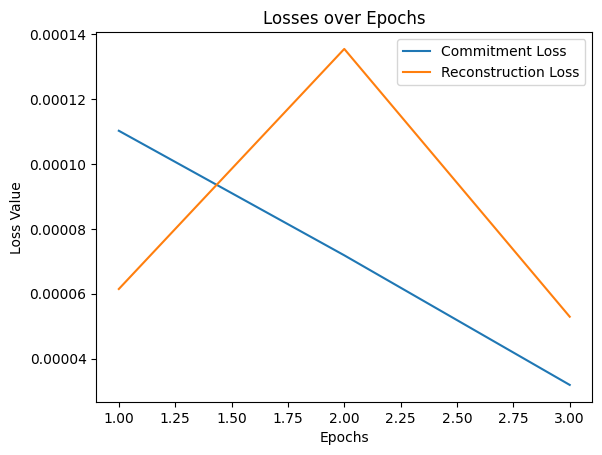

In [27]:
import numpy as np

# Load the NumPy array from file
array = np.load('/users/zboucher/iris/src/models/tokenizer/metrices.npy', allow_pickle=True)

import matplotlib.pyplot as plt

metrics = array  # List of 79 metrics dictionaries

# Create lists to store the loss values
total_losses = []
commitment_losses = []
reconstruction_losses = []
perceptual_losses = []

# Extract the loss values from each metrics dictionary
for metric in metrics:
    total_losses.append(metric["<class '__main__.Tokenizer'>/train/total_loss"])
    commitment_losses.append(metric["tokenizer/train/commitment_loss"])
    reconstruction_losses.append(metric["tokenizer/train/reconstruction_loss"])
    #perceptual_losses.append(metric["tokenizer/train/perceptual_loss"])

# Plot the losses
epochs = range(1, len(metrics) + 1)

#plt.plot(epochs, total_losses, label='Total Loss')
plt.plot(epochs, commitment_losses, label='Commitment Loss')
plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
#plt.plot(epochs, perceptual_losses, label='Perceptual Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Losses over Epochs')
plt.legend()
plt.show()


In [17]:
import matplotlib.pyplot as plt
losses_per_epoch = []
for epoch in range(0, 70):
    loss_per_epoch = metrics[f'{str(Tokenizer)}/train/total_loss']
    losses_per_epoch.append(loss_per_epoch)
# Assuming you have a list or array of losses named 'losses_per_epoch'
epochs = range(epoch_start, num_epochs)

plt.plot(epochs, losses_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses per Epoch')
plt.show()

NameError: name 'metrics' is not defined

torch.Size([1, 1, 256, 256])


NameError: name 'a_r1_display' is not defined

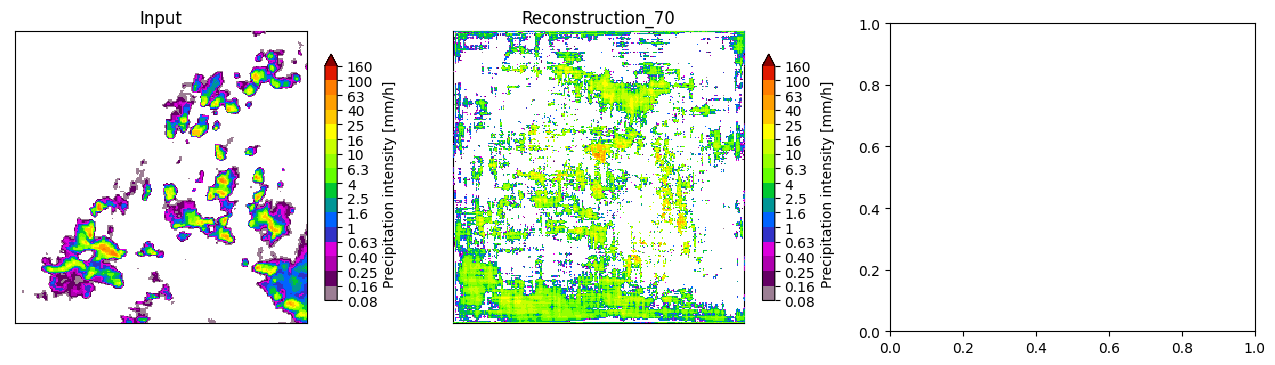

In [35]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cuda:1'
pcc_average = 0
tokenizer=tokenizer.to(device)
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break

    
    checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/checkpoints/vqvae_epoch70', map_location=device)
    optimizer_tokenizer.state_dict()
    image = images[0]
    image = image.unsqueeze(1)
    image = image[3:4, :, :, :]
    a= Variable(image).to(device)  # batch x
    print(input_image.size())
    a_r = tokenizer.encode_decode(a)
    
    
            #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(1):
        #a_display = (input_image[t,0,:,:].to('cpu').detach().numpy()+1)/2*128
        #a_r_display = (a_r[t,0,:,:].to('cpu').detach().numpy()+1)/2*128
        a_display = a[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        #a_r1_display = a_r1[t,0,:,:].to('cpu').detach().numpy()*40
        #a_r2_display = a_r2[t,0,:,:].to('cpu').detach().numpy()*40
        
        #np.save('reconstruct_sample{}_gt'.format(i+1), a_display)
        #np.save('reconstruct_sample{}_vqgan1'.format(i+1), a_r_display)
        #np.save('reconstruct_sample{}_vqgan2'.format(i+1), a_r2_display)
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        # scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        # scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        # scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        #scores_cont2 = det_cont_fct(a_r2_display, a_display, thr=0.1)
        # scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        # pcc_average += float(np.around(scores_cont['corr_p'],3))
        # if True:
        #     print('MSE:', np.around(scores_cont['MSE'],3), 
        #             'MAE:', np.around(scores_cont['MAE'],3), 
        #             'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
        #             'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
        #             'CSI(2mm):', np.around(scores_cat2['CSI'],3),
        #             'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
        #             'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
        #             'ACC(2mm):', np.around(scores_cat2['ACC'],3),
        #             'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
        #             'FSS(1km):', np.around(scores_spatial[0][0],3),
        #             'FSS(10km):', np.around(scores_spatial[1][0],3),
        #             'FSS(20km):', np.around(scores_spatial[2][0],3),
        #             'FSS(30km):', np.around(scores_spatial[3][0],3)
        #             )  
        plt.figure(figsize=(16, 4))
        plt.subplot(131)
        plot_precip_field(a_display, title="Input")
        plt.subplot(132)
        plot_precip_field(a_r_display, title="Reconstruction_70")
        plt.subplot(133)
        plot_precip_field(a_r1_display, title="Reconstruction_80")
        #plt.subplot(144)
        #plot_precip_field(a_r2_display, title="Reconstruction_80epoch")
        plt.tight_layout()
        plt.show()
print('pcc_average:', pcc_average/i)